In [3]:
#Method for calculating Markov transition matrix with nice steady state properties... minimise sq err
srand(1)
using JuMP, CPLEX



function Transition()
    rawData = round(readcsv("countryRowGrowth.csv"),2)

    global data = zeros(Int, 1,2)

    nCountries = size(rawData)[1]
    nYears = size(rawData)[2]

    minGrid = .85
    maxGrid = 1.14
    increment = .01
    
    global nStates = length(minGrid:increment:maxGrid)

    
    function valueToIndex(value)

        global index = convert(Int, round((value - minGrid)/increment + 1,0))

    end

    global vGrowthGrid = collect(minGrid:increment:maxGrid)
    global nGrowthGrid = length(vGrowthGrid)

    growthMat = zeros(nCountries, nYears)

    for m = 1:nCountries
        for n = 1:nYears
            if rawData[m,n] < 1000000
                growthMat[m,n] = vGrowthGrid[indmin(abs(vGrowthGrid .- rawData[m,n]))]
            end
        end
    end

    markov = zeros(nGrowthGrid,nGrowthGrid)



    for i = 1:nCountries
        for j = 1:nYears-1
            if rawData[i,j] < 1000000
                if rawData[i,j+1] < 1000000

                    x = convert(Int64,valueToIndex(growthMat[i,j]))
                    y = convert(Int64,valueToIndex(growthMat[i,j+1]))
                    
                    data= vcat(data, [valueToIndex(growthMat[i,j]), valueToIndex(growthMat[i,j+1])]')

                    markov[x,y] +=1
                end
            end

        end
    end

    for k = 1:nGrowthGrid
        markov[k,:] = markov[k,:]./sum(markov[k,:])
    end


    global mTransition = markov
    global data = data[2:end,:]
    global nData = length(data[2:end,1])
    global tallyState = hist(data[:,1], 1-.5:1:nStates+.5)[2]
    global s = tallyState/sum(tallyState)
end
Transition()
#mTransition is what we're shooting for
#vGrowthGrid is "rates" in the exstimation code



nStates = length(s)

states = collect(1:length(vGrowthGrid))




M = length(vGrowthGrid)
N = length(vGrowthGrid)

ONE = ones(M)

m = Model(solver = CplexSolver())

@variable(m, 0 <= T[1:M,1:N] <= 1)

@variable(m, topObj)



one = ones(M)
i = 1:M



@constraint(m, T'*s .== s)

@constraint(m, T*ONE .== ONE)

#@constraint(m, T .<= ones(M,M))
#@constraint(m, T .>= zeros(M,M))


@constraintref constraintFOSD[1:M]
for i = 1:M-1
    j = 1:M
    #constraintFOSD[i] = @constraint(m, sum(T[i,j]*rates[j]) <= sum(T[i+1,j]*rates[j]))
end

@constraint(m, T[1:M-1,:]*vGrowthGrid .<= T[2:M,:]*vGrowthGrid)

topObjVal = 0
#for a = 1:nData
    #topObjVal += @expression(m, ref, T[data[a,1], data[a,2]] - log(1+e.^T[data[a,1], data[a,2]]))
#    topObjVal += @expression(m,ref, T[data[a,1], data[a,2]] - )
#end

#what we shoot for
empDist = zeros(M,M)
for i = 1:nData

    x = convert(Int, data[i,1])
    y = convert(Int, data[i,2])

    if M >= x >= 1
        if M >= y >= 1
            empDist[x,y] +=1
        end
    end
end



for a = 1:nData
    topObjVal += @expression(m, ref, (T[states[data[a,1]], states[data[a,2]]] - 1)^2)
    
    for b in setdiff(states,data[a,2])
            topObjVal += @expression(m, ref, (T[states[data[a,1]], b])^2)
    end
end

@constraint(m, topObj == topObjVal)


@objective(m, Min, topObj) 
solve(m)
#getdual(T)
#print(m)
mTransition = getvalue(T)

 in depwarn(::String, ::Symbol) at .\deprecated.jl:64
 in #hist!#1016(::Bool, ::Function, ::Array{Int64,1}, ::Array{Int64,1}, ::FloatRange{Float64}) at .\deprecated.jl:630
 in hist(::Array{Int64,1}, ::FloatRange{Float64}) at .\deprecated.jl:645
 in Transition() at .\In[3]:70
 in include_string(::String, ::String) at .\loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\Ryan\.julia\v0.5\IJulia\src\execute_request.jl:157
 in eventloop(::ZMQ.Socket) at C:\Users\Ryan\.julia\v0.5\IJulia\src\eventloop.jl:8
 in (::IJulia.##13#19)() at .\task.jl:360
while loading In[3], in expression starting on line 73


Tried aggregator 1 time.
QP Presolve eliminated 2 rows and 58 columns.
Reduced QP has 87 rows, 844 columns, and 3260 nonzeros.
Reduced QP objective Q matrix has 784 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 4 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1682
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.08 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 4
  Rows in Factor            = 87
  Integer space required    = 178
  Total non-zeros in factor = 2612
  Total FP ops to factor    = 95432
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  5.7455460e+006 -5.7877100e+006 1.10e+004 1.60e+004 1.16e+006
   1  2.2056116e+003 -2.5825005e+003 8.25e+001 1.21e+002 8.71e+003
   2  1.8528609e+003  6.5700413e+002 2.10e+001 3.07e+001 2.21e+003
   3  1.8277477e+003  1.5562042e+003 4.84e+000 7.07e+000 5.10e+002
   4  1.8254712e+003  1.7685

30×30 Array{Float64,2}:
 0.0338322    0.0318305    0.0        …  0.0431384    0.135172   
 0.155915     8.94505e-12  0.0           0.0305653    0.0390563  
 0.0251551    0.0255734    0.0260029     0.0434505    0.0445202  
 3.4778e-11   3.84038e-11  0.0           0.0124115    0.0195209  
 0.0250421    0.0254775    0.0259237     0.0432993    0.0443096  
 0.0175908    0.0163316    0.0        …  3.85115e-11  3.85216e-11
 0.0152998    0.0146633    0.0           3.50888e-11  0.174414   
 0.0507063    0.0465056    0.0           8.22479e-12  7.68499e-12
 2.50094e-12  2.78496e-12  0.0           0.0310284    0.0385642  
 0.0185405    0.017833     0.0           9.43919e-12  1.02381e-11
 0.0672403    3.21932e-11  0.0        …  0.00292555   0.00731328 
 0.0233698    0.0247475    0.0           0.0363902    0.0086363  
 1.40214e-10  1.22915e-9   0.0           0.000230763  0.00433256 
 ⋮                                    ⋱                          
 0.011314     1.26582e-10  0.0           0.000409089

In [7]:
using PyPlot, StatsBase


function main(sigma)
    
    omega = .59


    

    
    riData = readcsv("IntDebtGreece.csv")#readcsv("IntDebtEuro.csv")#
    empDistBonds =  riData[:,2]./100
    
    empDistGDP = vGrowthGrid
    global vGridProductivity = t*sort(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true))#t*sort(vcat(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true),.7:.01:1))#
    
    lenData = size(empDistBonds)[1]
    Err = zeros(lenData)
    sqErr = zeros(lenData)
    global nGridProductivity = length(vGridProductivity)

    # Transition matrix


    # We generate the grid of bonds
    global vGridBonds = sort(vcat(empDistBonds,collect(.01:.01:bbar)))#sort(vcat(.01:.02:bbar, empDistBonds))
    global nGridBonds = length(vGridBonds)
    

    #convert(UInt64, nGridRenegot)
    
    findU = zeros(nGridBonds,nGridU)
    vGridABar = 1:nGridBonds
    global riAbar = ones(Int, nGridBonds, nGridU) #this is the index of the "reservation default at level of bond holdings
    bbeta = ones(nGridBonds)
    
    newriAbar = ones(Int, nGridBonds, nGridU)
    global ri = zeros(nGridBonds, nGridProductivity, nGridU)
    repayTot = zeros(nGridBonds,nGridProductivity)
    vec = zeros(due,nGridBonds)
    
    global nGridPrductivity = length(vGridProductivity)
    
    function restructure(bonds)
        differenceSq = zeros(nGridBonds)
        for currentDebt = 1:nGridBonds
            differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - phi*vGridBonds[bonds])
        end
        global renegotIndex = findmin(differenceSq)[2]
        global renegotValue = findmin(differenceSq)[1]
    end 

    restructure(nGridBonds)
    maxRenegot = renegotValue
    nGridRenegot = renegotIndex
    
    # 3. Required matrices and vectors

    #mOutput           = zeros(nGridCapital,nGridProductivity)
    mValueFunction    = zeros(nGridBonds,nGridProductivity)
    VD = ones(nGridRenegot, nGridProductivity)
    
    #store results for each U
    global VSU = zeros(nGridBonds, nGridProductivity, nGridU)
    global VDU = zeros(nGridRenegot, nGridProductivity, nGridU)
    global PolicyU = zeros(nGridBonds,nGridProductivity,nGridU)
    global PolicyUIndex = zeros(Int, nGridBonds,nGridProductivity,nGridU)
    
    mValueFunctionNew = zeros(nGridBonds,nGridProductivity)
    mPolicyFunction   = zeros(nGridBonds,nGridProductivity)
    global mPolicyFunctionIndex = zeros(Int, nGridBonds,nGridProductivity)
    expectedValueFunction = zeros(nGridBonds,nGridProductivity)
    
    global mDefault = zeros(nGridBonds, nGridProductivity,nGridU)
    global vSqErr = zeros(nGridU)


   
    # 4. We pre-build output for each point in the grid

    #mOutput = (vGridCapital.^aalpha)*vGridProductivity;

    # 5. Main iteration
    UIndex = 0
   for UIndex = 1:nGridU 
        ubar = vGridU[UIndex]
        riDiff = 1
        ValueHighSoFar = -100000
        
        #not good
        riAbar[:,UIndex] = ones(nGridBonds)
        newriAbar[:,UIndex] = ones(nGridBonds)
        
        mValueFunctionNew = zeros(nGridBonds,nGridProductivity)
        mPolicyFunction   = zeros(nGridBonds,nGridProductivity)
        global mPolicyFunctionIndex = zeros(Int, nGridBonds,nGridProductivity)
        expectedValueFunction = zeros(nGridBonds,nGridProductivity)
        
        mValueFunction    = zeros(nGridBonds,nGridProductivity)
        VD = ones(nGridRenegot, nGridProductivity)
        
        while riDiff > 0 
            maxDifference = 10.0
            tolerance = .001
            iteration = 0
            
            a = 0
            for a = 1:nGridBonds
                for b = 1:nGridProductivity
                    ri[a, b, UIndex] = ((1+r0 - phi*(1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]]))/
                    (1 - (1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]])) - 1)
                    #(1+r0)/(1 - (riAbar[a]-1)*(1 - omega)/nGridProductivity)-1
                    for i = 1:due
                        vec[i,:] = (1/due) ./((1+ri[a,b, UIndex]).^i)
                    end
                
                
                repayTot[a,b] = 1 ./sum(vec[:,a])
                
                bbeta[a] = (1 - (1-omega).*sum(mTransition[b,1: riAbar[a, UIndex]]))/(1 + r0)
                end
            end
            


            while(maxDifference > tolerance)
                defprod = 0
                
                
                
                expectedValueFunction = mValueFunction*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma);
                global expectedVD = VD*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                expectedProductivity = vGridProductivity'*mTransition
                bondsChoice  = copy(vGridBonds[1])
                bondsChoiceIndex = 1
                
                for count = 1:50
                    expectedVD = VD*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                    for renegotiatedDebt = 1:nGridRenegot
                        for defprod =  1:nGridProductivity # all default productivity levels... could actually reduce nGridProd to the highest level where default happens
                            defspend = t#vGridProductivity[defprod]::Float64
                            nextDebtIndex = findmin([nGridRenegot, findmin(
                                abs(vGridBonds - phi.*vGridBonds[renegotiatedDebt]./((1/t).*vGridProductivity[defprod])))[2]])[1]


                            VD[renegotiatedDebt,defprod] = ((defspend^(1 - sigma))/(1 - sigma) + bbeta[nGridBonds] * 
                            gamma * expectedValueFunction[nextDebtIndex,defprod] +
                            bbeta[nGridBonds]*(1 - gamma)*expectedVD[nextDebtIndex, defprod])
                        end
                    count = count+1
                    
                    end
                end
                
                expectedVD = VD*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                nProductivityToday = 0
                for nProductivityToday = 1:nGridProductivity
                    nBondsToday = 0
                    for nBondsToday = 1:nGridBonds
                        
                        renegotIndex = findmin([nGridRenegot, findmin(
                            abs(vGridBonds - phi.*vGridBonds[nBondsToday]./((1/t).*vGridProductivity[nProductivityToday])))[2]])[1]
                        #restructure(nBondsToday./(nProductivityToday.*(1./t)))
                        valueHighSoFar = -100000000000
                        nBondsNextPeriod = 0
                        for nBondsNextPeriod = 1:nGridBonds #can I vectorize this part?
                                
                            if nProductivityToday > riAbar[nBondsToday, UIndex] - 1
                                
                                #TodTomDebtDiff = vGridProductivity[nProductivityToday]*vGridBonds[nBondsNextPeriod]/t - ((due - 1)/due)vGridBonds[nBondsToday]
                                
                                
                                #leftForCons = TodTomDebtDiff/(repayTot[nBondsNextPeriod,nProductivityToday])
                                
                                
                                govspend = (t + (1/t)vGridProductivity[nProductivityToday].*
                                vGridBonds[nBondsNextPeriod]/(1 + ri[nBondsNextPeriod, nProductivityToday, UIndex]) -
                                vGridBonds[nBondsToday])
                                #vGridProductivity[nProductivityToday] - (1/due)*vGridBonds[nBondsToday] + leftForCons
                               

                                if govspend>0
                                    valueProvisional = ((govspend^(1 - sigma)) /(1 - sigma)
                                    + bbeta[nBondsNextPeriod]*expectedValueFunction[nBondsNextPeriod,nProductivityToday])
                                else  
                                    valueProvisional = (((t).^(1 - sigma))./(1 - sigma) +
                                    bbeta[nGridBonds].*expectedVD[renegotIndex, nProductivityToday] - ubar) 
                                    bondsChoiceIndex = renegotIndex
                                    bondsChoice = vGridBonds[renegotIndex]
                                end

                                if valueProvisional > valueHighSoFar

                                    valueHighSoFar = copy(valueProvisional)
                                    bondsChoice = copy(vGridBonds[nBondsNextPeriod])
                                    bondsChoiceIndex = copy(nBondsNextPeriod)
                                end
                            else
                                valueHighSoFar = (((t).^(1 - sigma))./(1 - sigma) +
                                bbeta[nGridBonds].*expectedVD[renegotIndex, nProductivityToday] - ubar) 
                                bondsChoice = vGridBonds[renegotIndex] # this isn't true if saved by IMF, need to calc new bond holdings
                                bondsChoiceIndex = renegotIndex
                            end
                        end
                        mValueFunctionNew[nBondsToday,nProductivityToday] = copy(valueHighSoFar)
                        mPolicyFunction[nBondsToday,nProductivityToday] = copy(bondsChoice)
                        mPolicyFunctionIndex[nBondsToday,nProductivityToday] = copy(bondsChoiceIndex)
                        
                    end
                end

                
                maxDifference  = maximum(abs(mValueFunctionNew - mValueFunction))
                #println(mValueFunctionNew-mValueFunction)
                mValueFunction    = copy(mValueFunctionNew)
                iteration = iteration+1
                mValueFunctionNew = zeros(nGridBonds, nGridProductivity)



            end

            risk = 0
            riDiff = 0
            for risk = 1:nGridBonds #risk is index of bonds today
                restructure(risk)
                expectedValueFunction = mValueFunction*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                expectedVD = VD*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                if riAbar[risk, UIndex] < nGridProductivity 
                    
            
                    
                    spend = (t + (1/t)*vGridProductivity[riAbar[risk]].*vGridBonds[mPolicyFunctionIndex[risk,riAbar[risk]]]./
                    (1 + ri[mPolicyFunctionIndex[risk,riAbar[risk]], UIndex]) - vGridBonds[risk])

                    
                    
                    

                    if spend >0
                        forcedSol = ((spend[1]^(1 - sigma))./(1 - sigma) + bbeta[risk]*
                        expectedValueFunction[mPolicyFunctionIndex[risk, riAbar[risk, UIndex]], riAbar[risk, UIndex]] )
                    else
                        forcedSol = -100000000
                    end
                    
                    nextDebtIndex = findmin([nGridRenegot, findmin(
                        abs(vGridBonds - phi.*vGridBonds[risk]./((1/t).*vGridProductivity[riAbar[risk, UIndex]])))[2]])[1]
                    forcedDef = (((t)^(1 - sigma))/(1 - sigma) +
                    bbeta[nGridBonds]*expectedVD[nextDebtIndex, riAbar[risk, UIndex]]) - ubar

                    if forcedSol[1] <= forcedDef[1]
                        #newriAbar[risk:nGridBonds] = min(riAbar[risk:nGridBonds] + ones(nGridBonds - risk + 1),nGridProductivity*ones(nGridBonds 
                        #- risk + 1))
                        newriAbar[risk, UIndex] = min(newriAbar[risk, UIndex] + 1, nGridBonds)
                        if risk>1
                            for increase =  risk:nGridBonds-1
                                if  newriAbar[increase, UIndex] > newriAbar[increase + 1, UIndex]
                                    newriAbar[increase + 1, UIndex:nGridU] += 1
                                end
                            end
                        end
                        #if risk > 1
                        #    newriAbar = vcat(riAbar[1:(risk - 1)], min(min(riAbar[risk:nGridBonds] + 1,ones(nGridBonds - risk + 1)*nGridProductivity),
                        #    ones

                        #else
                        #    newriAbar = min(riAbar + 1,nGridProductivity)
                        #end

                    else
                        newriAbar[risk, UIndex:nGridU] = copy(riAbar[risk, UIndex])
                    end
                    
                else
                    newriAbar[risk, UIndex:nGridU] = nGridProductivity
                    
                    #riDiff = 0
                    #break #cannot raise the cuttoff any higher
                end
                riDiff = abs(sum(newriAbar - riAbar)) + riDiff
                riAbar = copy(newriAbar)
            end

        end    
        
        m = 1
        n = 1
        
        for m = 1:nGridBonds
            for n = 1:nGridProductivity
                if riAbar[m, UIndex] > n
                    mDefault[m,n,UIndex] = 1
                end
            end
        end
        #find level of bonds s.t no default ever happens maxSolBonds
        maxSolBonds = zeros(nGridProductivity)
        x = 1
        y = 1
        for x = 1:nGridProductivity
            for y = 1:nGridBonds
                restructure(y)
                if x >= riAbar[y, UIndex]
                    maxSolBonds[x] = y
                else
                    maxSolBonds[x] = renegotIndex
                end

            end
        end
        p = 1
        q = 1

        for a = 1:nGridBonds
            for b = 1:nGridProductivity
                ri[a, b, UIndex] = ((1+r0 - phi*(1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]]))/
                (1 - (1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]])) - 1)

            end
        end
        
        dataInd = 0
        for dataInd = 1:lenData
            dataIndInComp= find(vGridBonds.==empDistBonds[dataInd])[1]
            Err[dataInd] = ri[dataIndInComp[1],1, UIndex] - riData[dataInd,1]./100
        end
        
        VSU[:,:,UIndex] = mValueFunction
        VDU[:,:,UIndex] = VD - ubar
        PolicyU[:,:,UIndex] = mPolicyFunction
        PolicyUIndex[:,:,UIndex] = mPolicyFunctionIndex

        
        sqErr = Err'*Err
 
        vSqErr[UIndex] = sqErr[1]

    end
    

    global vSqErr = -vSqErr'
    
    #Steady State Bonds Distribution

    global optimalUIndex = findmax(vSqErr)[2]
    global uii = vGridU[optimalUIndex]
    global bondsTodayToTomorrowProb = zeros(nGridBonds,nGridBonds)
    
    ssTransition = mTransition^10000
    
    global muBondsProd = zeros(nGridProductivity*nGridBonds, nGridProductivity*nGridBonds)

    
    for bToday = 1:nGridBonds
        for gToday = 1:nGridProductivity
            for bTom = 1:nGridBonds
                for gTom = 1:nGridProductivity
                    if PolicyUIndex[bToday,gToday] == bTom
        #row of bonds to bonds matrix is the tally function, check to be sure that prime is working
                        muBondsProd[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom-1) + gTom] += mTransition[gToday,gTom]
                    end
                end
            end
        end
    end
    

    


end


main (generic function with 1 method)

.


In [8]:


gamma = .204
    t = .25#.4#
    phi =.62#.95#


 bbar = 1.7#2.1#
    nGridProductivitySample = M
nGridProductivity = M
    due = 1#3#
r0 = .04
theta = .7
riData = readcsv("IntDebtGreece.csv")#readcsv("IntDebtEuro.csv")#
empDistBonds =  riData[:,2]./100
global vGridBonds = sort(vcat(empDistBonds,collect(.01:.01:bbar)))
global nGridBonds = length(vGridBonds)
    function restructure(bonds)
        differenceSq = zeros(nGridBonds)
        for currentDebt = 1:nGridBonds
            differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - phi*vGridBonds[bonds])
        end
        global renegotIndex = findmin(differenceSq)[2]
        global renegotValue = findmin(differenceSq)[1]
    end 

    restructure(nGridBonds)
    maxRenegot = renegotValue
    nGridRenegot = renegotIndex


empDistGDP = vGrowthGrid
global vGridProductivity = t*vGrowthGrid#sort(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true))#t*sort(vcat(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true),.7:.01:1))#

lenData = size(empDistBonds)[1]


function findBond(bonds)
    differenceSq = zeros(nGridBonds)
    for currentDebt = 1:nGridBonds
        differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - bonds)
    end
    global findBondIndex = findmin(differenceSq)[2]
    global findBondGrow = findmin(differenceSq)[1]
end 

function calcPerDef(range)
    
    nBondProd = nGridBonds*nGridProductivity
    
    #nGridBond = nGridBonds*nGridProductivity

    global nSigma = length(range)
    global perInDefault = zeros(nSigma)
    global perDefaultingThisYear = zeros(nSigma)

    global perThreatening = zeros(nSigma)
    global ssMuVec = zeros(nBondProd)
    #+epsilon, -epsilon, true

    global mValueS = zeros(nGridBonds,nGridProductivity, nSigma)
    global mValueD = zeros(nGridRenegot,nGridProductivity, nSigma)
    global storePolicy = zeros(nGridBonds,nGridProductivity, nSigma)
    global storeIntRate = zeros(nGridBonds,nGridProductivity, nSigma)
    
    
    global muBondsProdAdj = zeros(nBondProd,nBondProd)
    penaltyBoxAdj = zeros(nBondProd,nBondProd)
    global penaltyBoxShaker = zeros(nBondProd, nBondProd)
    
    global fixed = ones(nBondProd)/nBondProd
    freeNew = zeros(nBondProd)
    
    global free = zeros(nBondProd)
    fixedNew = zeros(nBondProd)
    
    global storeFree = zeros(nBondProd, nSigma)
    global storeFixed = zeros(nBondProd, nSigma)
    
    global storeDefault = zeros(nBondProd, nSigma)
    global storeUii = zeros(nSigma)
    for sigmaIndex = 1:nSigma
        
   

        sigmaValue = range[sigmaIndex]
        
        if sigmaValue<=1
            global vGridU = sort(collect(1:.1:5), rev = true)
            global nGridU = length(vGridU)
        elseif 1<sigmaValue<=1.5
            global vGridU = sort(collect(3:.1:15), rev = true)
            global nGridU = length(vGridU)
        elseif 1.5<sigmaValue<=2.1
            global vGridU = sort(collect(10:.1:30), rev = true)
            global nGridU = length(vGridU)
        else
            global vGridU = sort(collect(20:1:70), rev = true)
            global nGridU = length(vGridU)
        end

        
        main(sigmaValue)
        
        
        println("Sigma=", sigmaValue, ", Uii=", uii)
        global mDefaultVec = reshape((mDefault[:,:,optimalUIndex])',1,nBondProd) #should probably be mDefault'
        mValueS[:,:,sigmaIndex] = VSU[:,:,optimalUIndex]
        mValueD[:,:,sigmaIndex] = VDU[:,:,optimalUIndex]
        storePolicy[:,:,sigmaIndex] = PolicyUIndex[:,:,optimalUIndex]
        storeIntRate[:,:,sigmaIndex] = ri[:,:,optimalUIndex]

        nBondProd = length(muBondsProd[1,:])
        A = zeros(nBondProd)
        for i = 1:nBondProd
            A[i] = sum(muBondsProd[i,:])
        end

        
        for j = 1:nBondProd

            muBondsProdAdj[j,:] = muBondsProd[j,:]/A[j]
        end
        
        
        #ssMu = muBondsProdAdj^10000

        #ssBondHoldings = zeros(nGridBonds)
        #for x = 1:nBondProd
        #    ssBondHoldings[fld(x-1,nGridProductivity)+1] = ssMu[1,x]
        #end

        



        diff1 = 10
        diff2 = 10
        count = 0
        iter1 = 0
        gamma = .21



        #free = muBondsProdAdj - penaltyBoxAdj
        
        while diff1 >= 10.0^-5
            
            penaltyBoxShaker = zeros(nBondProd,nBondProd)

   
            for bToday = 1:nGridBonds
                for gToday = 1:nGridProductivity
                    for gTom = 1:nGridProductivity
                        
                        findBond(bToday/(4*vGridProductivity[gToday]))
                        bTom = findBondIndex
                        
                        penaltyBoxShaker[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom - 1) + gTom] += (
                        fixed[(nGridProductivity)*(bToday-1) + gToday]*mTransition[gToday, gTom])
            
                    end
                end
            end
            
            fixedNew = ((1 - gamma).*ones(nBondProd)'*penaltyBoxShaker + (1 - theta).*free'.*mDefaultVec*muBondsProdAdj)'

            freeNew = (theta.*free'.*mDefaultVec*muBondsProdAdj  + free'.*(1 - mDefaultVec)*muBondsProdAdj
            + (gamma).*ones(nBondProd)'*penaltyBoxShaker)'
            
            
            diff1 = sum(abs(freeNew - free))
            
            free = copy(freeNew)
            fixed = copy(fixedNew)
            
            iter1 +=1
            
            #if mod(iter1,10) ==1
            #    println("iter1 = ", iter1, " total Free = ", sum(free), " total fixed = ", sum(fixed) )
            #end
            
            if iter1 >2000
                break
            end
            
            if sum(free+fixed) <=.9999
                println("low = ", iter1, " total Free = ", sum(free), " total fixed = ", sum(fixed) )
                break
            end
            
            if sum(free + fixed) >= 1.001
                println("high = ", iter1, " total Free = ", sum(free), " total fixed = ", sum(fixed) )
                break
            end
            
            freeNew = zeros(nBondProd)
            fixedNew = zeros(nBondProd)
            penaltyBoxShaker = zeros(nBondProd,nBondProd)
            
        end
        
        perThreatening[sigmaIndex] = sum(free'*mDefaultVec')
        perDefaultingThisYear[sigmaIndex] = (1 - theta)sum(free'*mDefaultVec')
                
        storeFree[:,sigmaIndex] = free
        storeFixed[:,sigmaIndex] = fixed
        storeDefault[:,sigmaIndex] = mDefaultVec
        storeUii[sigmaIndex] = uii
        
        println("Sigma = ", range[sigmaIndex], 
        ", Threatening = ", round(perThreatening[sigmaIndex],4),
        ", Defaulting = ", round(perDefaultingThisYear[sigmaIndex], 4))
    end
end

tic()
sigmaVec = vcat([.9,.99], collect(1.1:.1:2.5))
calcPerDef(sigmaVec)
toc()

Sigma=

0.9, Uii=5.0


.


Sigma = 0.9, Threatening = 0.0, Defaulting = 0.0
Sigma=0.99, Uii=5.0
Sigma = 0.99, Threatening = 0.0, Defaulting = 0.0
Sigma=1.1, Uii=15.0
Sigma = 1.1, Threatening = 0.0055, Defaulting = 0.0017
Sigma=1.2, Uii=15.0
Sigma = 1.2, Threatening = 0.0164, Defaulting = 0.0049
Sigma=1.3, Uii=15.0
Sigma = 1.3, Threatening = 0.0163, Defaulting = 0.0049
Sigma=1.4, Uii=15.0
Sigma = 1.4, Threatening = 0.0162, Defaulting = 0.0049
Sigma=1.5, Uii=15.0
Sigma = 1.5, Threatening = 0.0162, Defaulting = 0.0049
Sigma=1.6, Uii=30.0
Sigma = 1.6, Threatening = 0.0156, Defaulting = 0.0047
Sigma=1.7, Uii=30.0
Sigma = 1.7, Threatening = 0.0157, Defaulting = 0.0047
Sigma=1.8, Uii=30.0
Sigma = 1.8, Threatening = 0.0213, Defaulting = 0.0064
Sigma=1.9, Uii=30.0
Sigma = 1.9, Threatening = 0.0228, Defaulting = 0.0068
Sigma=2.0, Uii=30.0
Sigma = 2.0, Threatening = 0.0233, Defaulting = 0.007
Sigma=2.1, Uii=30.0
Sigma = 2.1, Threatening = 0.3225, Defaulting = 0.0967
Sigma=2.2, Uii=70
Sigma = 2.2, Threatening = 0.0109, Defa

536528.308555175

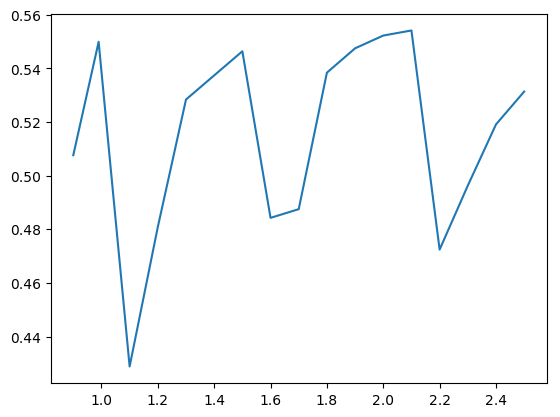

17-element Array{Float64,1}:
 0.507612
 0.549903
 0.428826
 0.480858
 0.528388
 0.537395
 0.546386
 0.484261
 0.487498
 0.53841 
 0.547496
 0.552256
 0.554146
 0.472424
 0.496293
 0.51911 
 0.531359

In [6]:
sumFixed = zeros(nSigma)
for i = 1:nSigma
    sumFixed[i] = sum(storeFixed[:,i])
end
plot(sigmaVec, sumFixed)
sumFixed

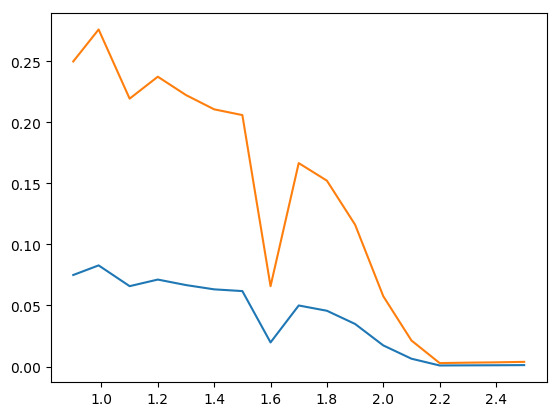

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000029025940>

In [71]:
plot(sigmaVec, perDefaultingThisYear, label = "% Defaulting")
plot(sigmaVec, perThreatening, label = "% Threatening")

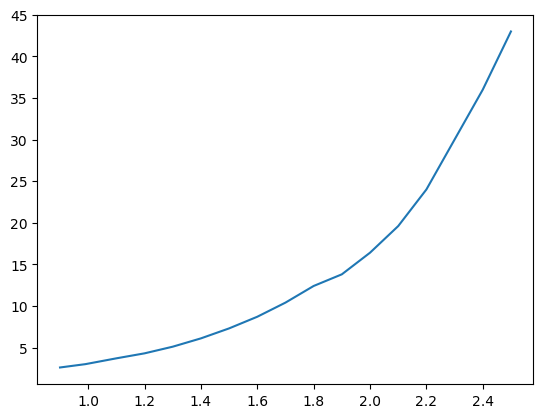

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003A067198>

In [102]:
plot(sigmaVec, storeUii, label = "Uii")


In [14]:
vSqErr

1×3 Array{Float64,2}:
 -0.0070451  -0.0070451  -0.0070451

In [18]:
sum(riAbar[:,1]- riAbar[:,2])

0

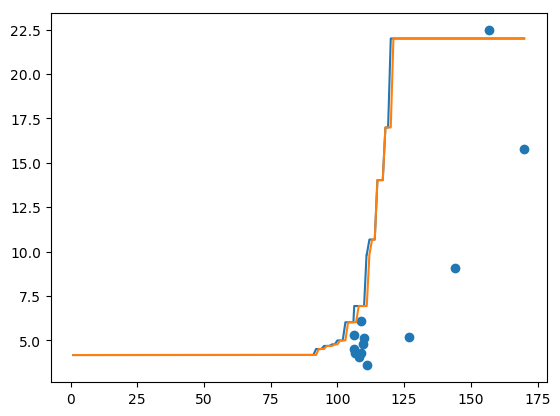

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002BE88630>

In [88]:
using PyPlot
riData = readcsv("IntDebtEuro.csv")
scatter(readcsv("IntDebtGreece.csv")[:,2],readcsv("IntDebtGreece.csv")[:,1])
plot(100*vGridBonds,100*ri[:,nGridProductivity,2])
plot(100*vGridBonds,100*ri[:,nGridProductivity,1])

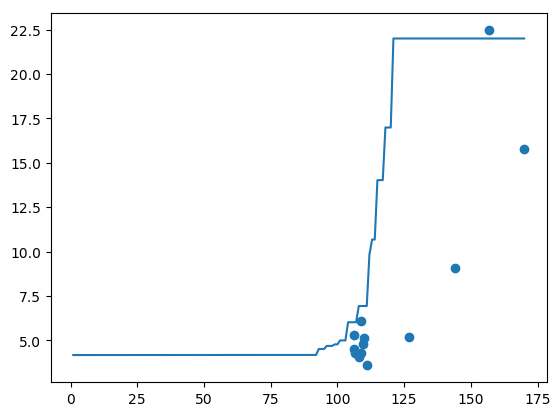

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000039844E10>

In [95]:
using PyPlot
riData = readcsv("IntDebtEuro.csv")
scatter(readcsv("IntDebtGreece.csv")[:,2],readcsv("IntDebtGreece.csv")[:,1])
plot(100*vGridBonds,100*ri[:,nGridProductivity,1])

In [ ]:
#test new main
using PyPlot, StatsBase


gamma = .204
    t = .25#.4#
    phi =.62#.95#


 bbar = 1.7#2.1#
    nGridProductivitySample = M
nGridProductivity = M
    due = 1#3#
r0 = .04
theta = .6
riData = readcsv("IntDebtGreece.csv")#readcsv("IntDebtEuro.csv")#
empDistBonds =  riData[:,2]./100
global vGridBonds = sort(vcat(empDistBonds,collect(.01:.01:bbar)))
global nGridBonds = length(vGridBonds)
    function restructure(bonds)
        differenceSq = zeros(nGridBonds)
        for currentDebt = 1:nGridBonds
            differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - phi*vGridBonds[bonds])
        end
        global renegotIndex = findmin(differenceSq)[2]
        global renegotValue = findmin(differenceSq)[1]
    end 

    restructure(nGridBonds)
    maxRenegot = renegotValue
    nGridRenegot = renegotIndex


empDistGDP = vGrowthGrid
global vGridProductivity = t*vGrowthGrid#sort(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true))#t*sort(vcat(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true),.7:.01:1))#

lenData = size(empDistBonds)[1]


function findBond(bonds)
    differenceSq = zeros(nGridBonds)
    for currentDebt = 1:nGridBonds
        differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - bonds)
    end
    global findBondIndex = findmin(differenceSq)[2]
    global findBondGrow = findmin(differenceSq)[1]
end 
sigma = 2.1


function main(thetaEpsilon)
    
    omega = thetaEpsilon

    global vGridU = sort(collect(19.6:.1:19.6), rev = true)
    global nGridU = length(vGridU)
    

    
    riData = readcsv("IntDebtGreece.csv")#readcsv("IntDebtEuro.csv")#
    empDistBonds =  riData[:,2]./100
    
    empDistGDP = vGrowthGrid
    global vGridProductivity = t*sort(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true))#t*sort(vcat(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true),.7:.01:1))#
    
    lenData = size(empDistBonds)[1]
    Err = zeros(lenData)
    sqErr = zeros(lenData)
    global nGridProductivity = length(vGridProductivity)

    # Transition matrix


    # We generate the grid of bonds
    global vGridBonds = sort(vcat(empDistBonds,collect(.01:.01:bbar)))#sort(vcat(.01:.02:bbar, empDistBonds))
    global nGridBonds = length(vGridBonds)
    

    #convert(UInt64, nGridRenegot)
    
    findU = zeros(nGridBonds,nGridU)
    vGridABar = 1:nGridBonds
    global riAbar = ones(Int, nGridBonds, nGridU) #this is the index of the "reservation default at level of bond holdings
    bbeta = ones(nGridBonds)
    
    newriAbar = ones(Int, nGridBonds, nGridU)
    global ri = zeros(nGridBonds, nGridProductivity, nGridU)
    repayTot = zeros(nGridBonds,nGridProductivity)
    vec = zeros(due,nGridBonds)
    
    global nGridPrductivity = length(vGridProductivity)
    
    function restructure(bonds)
        differenceSq = zeros(nGridBonds)
        for currentDebt = 1:nGridBonds
            differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - phi*vGridBonds[bonds])
        end
        global renegotIndex = findmin(differenceSq)[2]
        global renegotValue = findmin(differenceSq)[1]
    end 

    restructure(nGridBonds)
    maxRenegot = renegotValue
    nGridRenegot = renegotIndex
    
    # 3. Required matrices and vectors

    #mOutput           = zeros(nGridCapital,nGridProductivity)
    mValueFunction    = zeros(nGridBonds,nGridProductivity)
    VD = ones(nGridRenegot, nGridProductivity)
    
    #store results for each U
    global VSU = zeros(nGridBonds, nGridProductivity, nGridU)
    global VDU = zeros(nGridRenegot, nGridProductivity, nGridU)
    global PolicyU = zeros(nGridBonds,nGridProductivity,nGridU)
    global PolicyUIndex = zeros(Int, nGridBonds,nGridProductivity,nGridU)
    
    mValueFunctionNew = zeros(nGridBonds,nGridProductivity)
    mPolicyFunction   = zeros(nGridBonds,nGridProductivity)
    global mPolicyFunctionIndex = zeros(Int, nGridBonds,nGridProductivity)
    expectedValueFunction = zeros(nGridBonds,nGridProductivity)
    
    global mDefault = zeros(nGridBonds, nGridProductivity,nGridU)
    global vSqErr = zeros(nGridU)


   
    # 4. We pre-build output for each point in the grid

    #mOutput = (vGridCapital.^aalpha)*vGridProductivity;

    # 5. Main iteration
    UIndex = 0
    for UIndex = 1:nGridU 
        ubar = vGridU[UIndex]
        riDiff = 1

        while riDiff > 0 
            maxDifference = 10.0
            tolerance = .001
            iteration = 0
            
            a = 0
            for a = 1:nGridBonds
                for b = 1:nGridProductivity
                    ri[a, b, UIndex] = ((1+r0 - phi*(1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]]))/
                    (1 - (1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]])) - 1)
                    #(1+r0)/(1 - (riAbar[a]-1)*(1 - omega)/nGridProductivity)-1
                    for i = 1:due
                        vec[i,:] = (1/due) ./((1+ri[a,b, UIndex]).^i)
                    end
                
                
                repayTot[a,b] = 1 ./sum(vec[:,a])
                
                bbeta[a] = 1./(1 + r0)
                end
            end
            


            while(maxDifference > tolerance)
                defprod = 0
                
                
                
                expectedValueFunction = mValueFunction*mTransition';
                expectedProductivity = vGridProductivity'*mTransition
                bondsChoice  = copy(vGridBonds[1])
                bondsChoiceIndex = 1
                
                for count = 1:50
                    expectedVD = VD*mTransition'
                    for renegotiatedDebt = 1:nGridRenegot
                        for defprod =  1:nGridProductivity # all default productivity levels... could actually reduce nGridProd to the highest level where default happens
                            defspend = vGridProductivity[defprod]::Float64


                            VD[renegotiatedDebt,defprod] = ((defspend^(1 - sigma))/(1 - sigma) + bbeta[nGridBonds] * 
                            gamma * expectedValueFunction[renegotiatedDebt,defprod] +
                            bbeta[nGridBonds]*(1 - gamma)*expectedVD[renegotiatedDebt, defprod])
                        end
                    count = count+1
                    
                    end
                end
                nProductivityToday = 0
                for nProductivityToday = 1:nGridProductivity
                    nBondsToday = 0
                    for nBondsToday = 1:nGridBonds
                        restructure(nBondsToday)
                        valueHighSoFar = -100000000000
                        nBondsNextPeriod = 0
                        for nBondsNextPeriod = 1:nGridBonds
                                
                            if nProductivityToday > riAbar[nBondsToday, UIndex] - 1
                                
                                TodTomDebtDiff = vGridProductivity[nProductivityToday]*vGridBonds[nBondsNextPeriod]/t - ((due - 1)/due)vGridBonds[nBondsToday]
                                
                                
                                leftForCons = TodTomDebtDiff/(repayTot[nBondsNextPeriod,nProductivityToday])
                                
                                
                                govspend = vGridProductivity[nProductivityToday] - (1/due)*vGridBonds[nBondsToday] + leftForCons
                               

                                if govspend>0
                                    valueProvisional = ((govspend^(1 - sigma)) /(1 - sigma)
                                    + bbeta[nBondsNextPeriod]*expectedValueFunction[nBondsNextPeriod,nProductivityToday])
                                else  
                                    valueProvisional = VD[renegotIndex,nProductivityToday] - ubar
                                    bondsChoiceIndex = renegotIndex
                                    bondsChoice = vGridBonds[renegotIndex]
                                end

                                if valueProvisional > valueHighSoFar

                                    valueHighSoFar = copy(valueProvisional)
                                    bondsChoice = copy(vGridBonds[nBondsNextPeriod])
                                    bondsChoiceIndex = copy(nBondsNextPeriod)
                                end
                            else
                                valueHighSoFar = VD[renegotIndex, nProductivityToday] - ubar
                                bondsChoice = vGridBonds[renegotIndex] # this isn't true if saved by IMF, need to calc new bond holdings
                                bondsChoiceIndex = renegotIndex
                            end
                        end
                        mValueFunctionNew[nBondsToday,nProductivityToday] = copy(valueHighSoFar)
                        mPolicyFunction[nBondsToday,nProductivityToday] = copy(bondsChoice)
                        mPolicyFunctionIndex[nBondsToday,nProductivityToday] = copy(bondsChoiceIndex)
                        
                    end
                end

                for count = 1:10
                    expectedVD = VD*mTransition'
                    for carriedDebt = 1:nGridRenegot
                        for defprod =  1:nGridProductivity # all default productivity levels... could actually reduce nGridProd to the highest level where default happens
                            defspend = vGridProductivity[defprod]::Float64

                            VD[carriedDebt, defprod] = ((defspend^(1 - sigma))/(1 - sigma) + bbeta[nGridBonds] *
                            gamma * expectedValueFunction[carriedDebt,defprod] +
                            bbeta[nGridBonds]*(1 - gamma)*expectedVD[carriedDebt, defprod])
                        end
                    end
                    count = count+1
                end
                
                
                maxDifference  = maximum(abs(mValueFunctionNew - mValueFunction))
                mValueFunction    = copy(mValueFunctionNew)
                iteration = iteration+1
                mValueFunctionNew = zeros(nGridBonds, nGridProductivity)
                
                if mod(iteration,10)==0 #|| iteration == 1
                    println("UINdex", UIndex, " Iteration = ", iteration, " Sup Diff = ", maxDifference)
                end 

            end


            for risk = 1:nGridBonds #risk is index of bonds todayaoeu
                restructure(risk)
                expectedValueFunction = mValueFunction*mTransition'
                expectedVD = VD*mTransition'
                if riAbar[risk, UIndex] < nGridProductivity 
                    
            
                    
                    TodTomDebtDiff =  vGridProductivity[riAbar[risk,UIndex]]*mPolicyFunction[risk,riAbar[risk, UIndex]]/t - ((due - 1)/due)*vGridBonds[risk]
                                
                    leftForCons = TodTomDebtDiff./(repayTot[mPolicyFunctionIndex[risk,riAbar[risk, UIndex]]])
                                
                    
                    spend = vGridProductivity[riAbar[risk, UIndex]] - (1/due)*vGridBonds[risk] + leftForCons

                    
                    
                    
                    #spend = (vGridProductivity[riAbar[risk]] - vGridBonds[risk] + mPolicyFunction[risk,riAbar[risk]]./(1+
                    #ri[mPolicyFunctionIndex[risk,riAbar[risk]]]))
                    
                    #expConTomSol = vGridProductivity - vGridBonds[risk] + mPolicyFunction'[risk,:]./(ri[mPolicyFunction'[risk,:]])
                    #expConTomDef = vGridProductivity
                    if spend >0
                        forcedSol = ((spend[1]^(1 - sigma))./(1 - sigma) + bbeta[risk]*expectedValueFunction[mPolicyFunctionIndex[risk,riAbar[risk, UIndex]],
                            riAbar[risk, UIndex]] )
                    else
                        forcedSol = -100000000
                    end

                    forcedDef = (((vGridProductivity[riAbar[risk, UIndex]])^(1 - sigma))/(1 - sigma) +
                    bbeta[nGridBonds]*expectedVD[renegotIndex,riAbar[risk, UIndex]] - ubar)

                    if forcedSol[1] < forcedDef[1]
                        #newriAbar[risk:nGridBonds] = min(riAbar[risk:nGridBonds] + ones(nGridBonds - risk + 1),nGridProductivity*ones(nGridBonds 
                        #- risk + 1))
                        newriAbar[risk, UIndex] = min(newriAbar[risk, UIndex] + 1, nGridBonds)
                        if risk>1
                            for increase =  risk:nGridBonds-1
                                if  newriAbar[increase, UIndex] > newriAbar[increase + 1, UIndex]
                                    newriAbar[increase + 1, UIndex:nGridU] += 1
                                end
                            end
                        end
                        #if risk > 1
                        #    newriAbar = vcat(riAbar[1:(risk - 1)], min(min(riAbar[risk:nGridBonds] + 1,ones(nGridBonds - risk + 1)*nGridProductivity),
                        #    ones

                        #else
                        #    newriAbar = min(riAbar + 1,nGridProductivity)
                        #end

                    else
                        newriAbar[risk, UIndex:nGridU] = copy(riAbar[risk, UIndex])
                    end
                    
                else
                    newriAbar[risk, UIndex:nGridU] = nGridProductivity
                    
                    #riDiff = 0
                    #break #cannot raise the cuttoff any higher
                end
                riDiff = abs(sum(newriAbar - riAbar)) #should I take this out + riDiff
                riAbar = copy(newriAbar)
            end
            #newriAbar = ones(nGridBonds)
            
        println("Change in Ri = ", riDiff, "UIndex = ", UIndex," RiMaxBonds = ", riAbar[nGridBonds, UIndex])
        end
        
        m = 1
        n = 1
        
        for m = 1:nGridBonds
            for n = 1:nGridProductivity
                if riAbar[m, UIndex] > n
                    mDefault[m,n,UIndex] = 1
                end
            end
        end
        #find level of bonds s.t no default ever happens maxSolBonds
        maxSolBonds = zeros(nGridProductivity)
        x = 1
        y = 1
        for x = 1:nGridProductivity
            for y = 1:nGridBonds
                restructure(y)
                if x >= riAbar[y, UIndex]
                    maxSolBonds[x] = y
                else
                    maxSolBonds[x] = renegotIndex
                end

            end
        end
        p = 1
        q = 1

        for a = 1:nGridBonds
            for b = 1:nGridProductivity
                ri[a, b, UIndex] = ((1+r0 - phi*(1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]]))/
                (1 - (1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]])) - 1)

            end
        end
        
        dataInd = 0
        for dataInd = 1:lenData
            dataIndInComp= find(vGridBonds.==empDistBonds[dataInd])[1]
            Err[dataInd] = ri[dataIndInComp[1],1, UIndex] - riData[dataInd,1]./100
        end
        
        VSU[:,:,UIndex] = mValueFunction
        VDU[:,:,UIndex] = VD - ubar
        PolicyU[:,:,UIndex] = mPolicyFunction
        PolicyUIndex[:,:,UIndex] = mPolicyFunctionIndex

        
        sqErr = Err'*Err
 
        vSqErr[UIndex] = sqErr[1]

    end
    

    global vSqErr = -vSqErr'
    
    #Steady State Bonds Distribution

    global optimalUIndex = findmax(vSqErr)[2]
    global uii = vGridU[optimalUIndex]
    global bondsTodayToTomorrowProb = zeros(nGridBonds,nGridBonds)
    
    ssTransition = mTransition^10000
    
    global muBondsProd = zeros(nGridProductivity*nGridBonds, nGridProductivity*nGridBonds)

    
    for bToday = 1:nGridBonds
        for gToday = 1:nGridProductivity
            for bTom = 1:nGridBonds
                for gTom = 1:nGridProductivity
                    if PolicyUIndex[bToday,gToday] == bTom
        #row of bonds to bonds matrix is the tally function, check to be sure that prime is working
                        muBondsProd[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom-1) + gTom] += mTransition[gToday,gTom]
                    end
                end
            end
        end
    end
    

    


end
tic
main(.7)
toc
#see line 324

UINdex1 Iteration = 10 Sup Diff = 3.3056964265171302
UINdex1 Iteration = 20 Sup Diff = 2.168016791527023
UINdex1 Iteration = 30 Sup Diff = 1.4588032144889667
UINdex1 Iteration = 40 Sup Diff = 0.985009280865782
UINdex1 Iteration = 50 Sup Diff = 0.6645847031040262
UINdex1 Iteration = 60 Sup Diff = 0.44626204435810735
UINdex1 Iteration = 70 Sup Diff = 0.29875587538199966
UINdex1 Iteration = 80 Sup Diff = 0.19969245050440065
UINdex1 Iteration = 90 Sup Diff = 0.13333253975046944
UINdex1 Iteration = 100 Sup Diff = 0.08895772132260049
UINdex1 Iteration = 110 Sup Diff = 0.059323490910102805
UINdex1 Iteration = 120 Sup Diff = 0.03954901868216609
UINdex1 Iteration = 130 Sup Diff = 0.02635837153350451


LoadError: UndefVarError: uii not defined